# 1. Тема проекта, цели, используемые данные

__Тема проекта__ - исследовании данных о недвижимости в Москве, используемые для выполнения курсового проекта по другой дисциплине (предсказание цены по остальным параметрам при помощи различных моделей классчисекого машинного обучения).

__Цель__ - закрепить полученные в рамках этого знания, доработать выполненный ранее по другой дисциплине курсовой проект с учетом полученных знаний, а также получить представление о данных, имеющихся в них связях и закономерностях, и получить характеризующие их статистические параметры.

__Задачи__:
 1. Провести разведочный анализ данных:
    - определение средних, медиан, мод;
    - оценка выбросов и экстремальных значений;
    - заполнение пропусков и обработка выбросов.
 2. Провести проверку статистических гипотез:
     - проверка на нормальность;
     - проверка гипотез о том, что матожидание и дисперсия признаков, для которых были произведены замена пропусков и обработка выбросов, равны вычесленным по ним значениям матоожидания и дисперсии.
 3. Провести корреляционный анализ;
 4. Подготоить данные для регрессионого анализа и проведсти регрессионного анализа (целевой признак - цена);
 5. Провести дисперсионный анализ (попробую сделать по всем нижеперечисленным и посмотреть как и что получится):
     - проверка гипотезы о равенстве средней цены, распределенной по одному из признаков;
     - классификация по категории цены (так же новый признак - категория цены: дешевый сегмент, средницй ценовой сегмент или дорогой сегмент).

__Данные:__

Данные располагаются по ссылке https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data.

__Признаки:__

    Количественные:
    
    * Rooms - количество комнат
    * Square - площадь
    * LifeSquare - жилая площадь
    * KitchenSquare - площадь кухни
    * Ecology_1 - экологический показатель местности
    * Shops_1 - показатель, связанный с наличием магазинов, торговых центров
    * Healthcare_1 - показатель местности, связанный с охраной здоровья
    * Social_1, Social_2, Social_3 - социальные показатели местности
    * Price - цена квартиры

    Качественные:
    
    * Id - идентификационный номер квартиры
    * DistrictId - идентификационный номер района
    * Floor - этаж
    * HouseFloor - количество этажей в доме
    * HouseYear - год постройки дома
    * Helthcare_2 - показатель местности, связанный с охраной здоровья
    * Ecology_2, Ecology_3 - экологические показатели местности 
    * Shops_2 - показатель, связанный с наличием магазинов, торговых центров



# 2. Подключение библиотек и функций, загрузка данных

In [1]:
import numpy as np
import pandas as pd
import random as rnd

from scipy import stats

#Метрика для оценки качества предсказания модели
from sklearn.metrics import r2_score as r2

#Модуль для стандартизации данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Импорт моделей
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA

# Модули для визуализации данных
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns


%matplotlib inline

### Путь к датасету

In [2]:
DATASET_PATH = './data_Real_Estate_Price_Prediction.csv'

### Загрузка датасета

In [3]:
df = pd.read_csv(DATASET_PATH)

# 3. Разведочный анализ

## 3.1 Оценка целевого параметра - Цены

In [4]:
def density_hist_plot(data_frame:pd.DataFrame, features_name):
    """
    Функция получает на вход датафрейм и список признаков, для которых необходимо построить графики.
    Результатом работы является фигура, содержащая в себе 5 графиков - гистограмму, плотность распределения,
    плотность нормального распределения, среднее и медианное значения.
    """
    
    
    if type(features_name) is not list:
        features_name = [features_name]
    
    for name in features_name: 
        fig, ax = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(20, 8)
        
        sns.histplot(df[name], ax=ax[0], kde=True, legend=True, stat='density', label=f'Density of {name}')

        #график плотности распределения цены, если бы ее распределение подчинялось закону нормального распределения
        ox = np.linspace(df[name].min(), df[name].max(), 1000)
        oy = np.array([stats.norm.pdf(x=x, loc=df[name].mean(), scale=df[name].std()) for x in ox])

        sns.lineplot(x=ox, y=oy, ax=ax[0], color='red', legend=True, linewidth = 4, label=f'Normal density of {name}')


        #медиана и среднее значение
        ax[0].vlines(df[name].mean(), ymin=0, ymax=(oy.max() * 1.15), label='mean', color='red', linestyle='--', linewidth = 4)
        ax[0].vlines(df[name].median(), ymin=0, ymax=(oy.max() * 1.15), label='median', color='green', linestyle=':', linewidth = 4)

        ax[0].set_xlabel(name, fontsize=20)
        ax[0].set_ylabel('Density', fontsize=20)
        ax[0].legend(fontsize=14)

        
        #boxplot
        sns.boxplot(data=df[name], ax=ax[1], whis=1.5)
        ax[1].set_title(name)
        
        plt.show()
        
    return

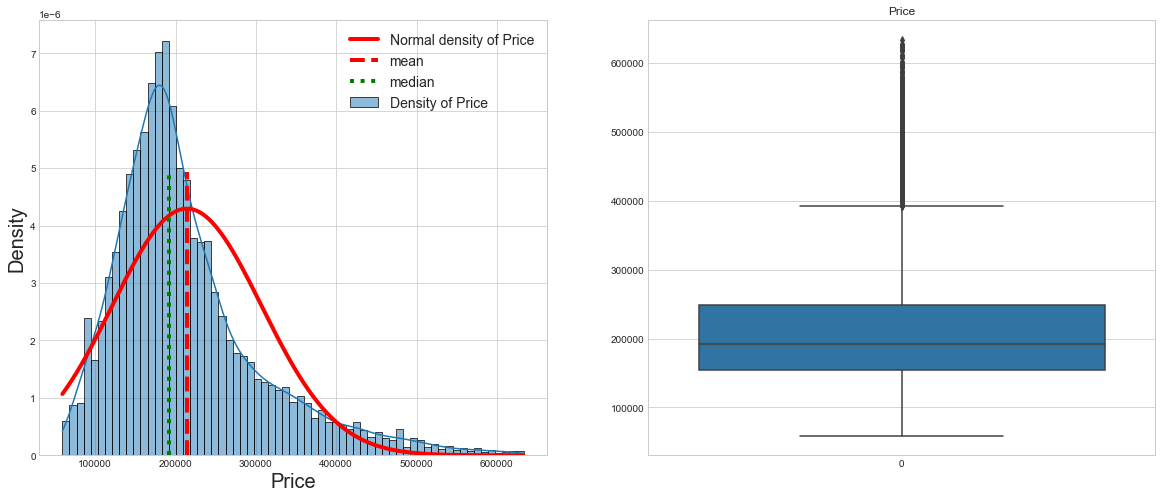

In [5]:
density_hist_plot(df, 'Price')

Согласно графика, распределение целевого параметра - цены, не соответствует нормальному распределению.

При этом согласно boxplot значения выше 400000, которые относятся к длинному правому хвосту, являются выбросами.

## 3.2 Оценка количественных признаков

In [6]:
#список количественных признаков
quantitative_features = [
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Ecology_1',
    'Shops_1',
    'Healthcare_1',
    'Social_1',
    'Social_2',
    'Social_3'
]

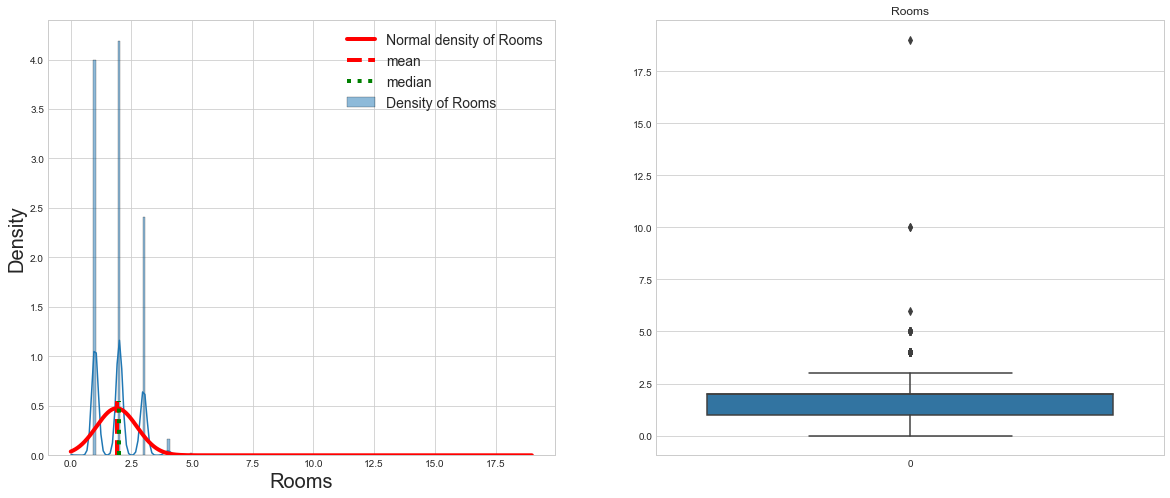

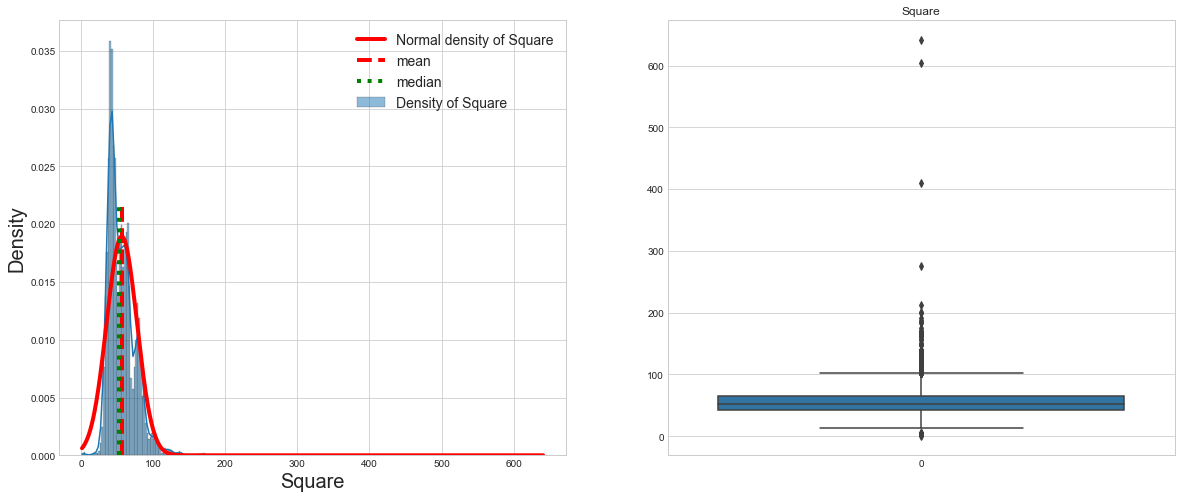

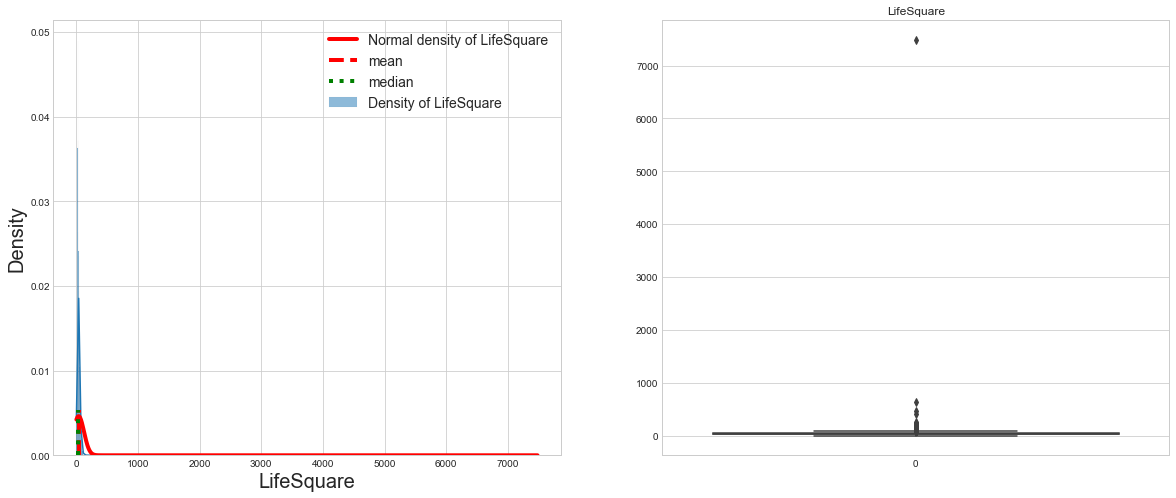

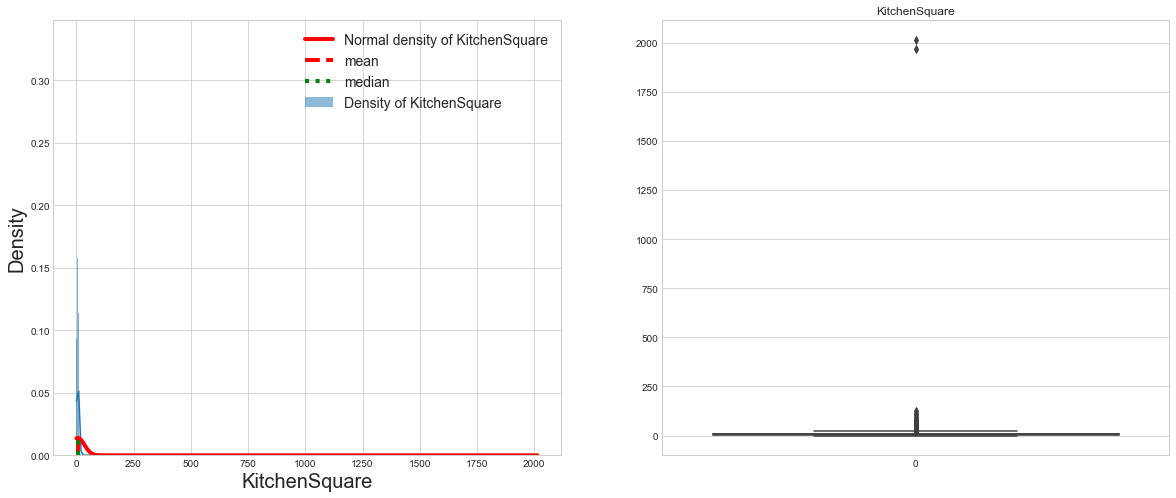

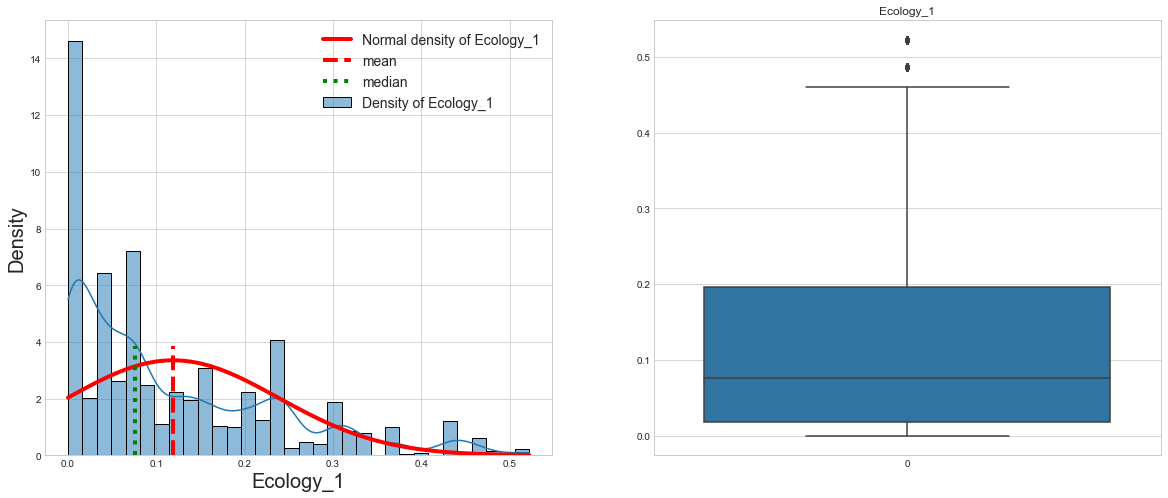

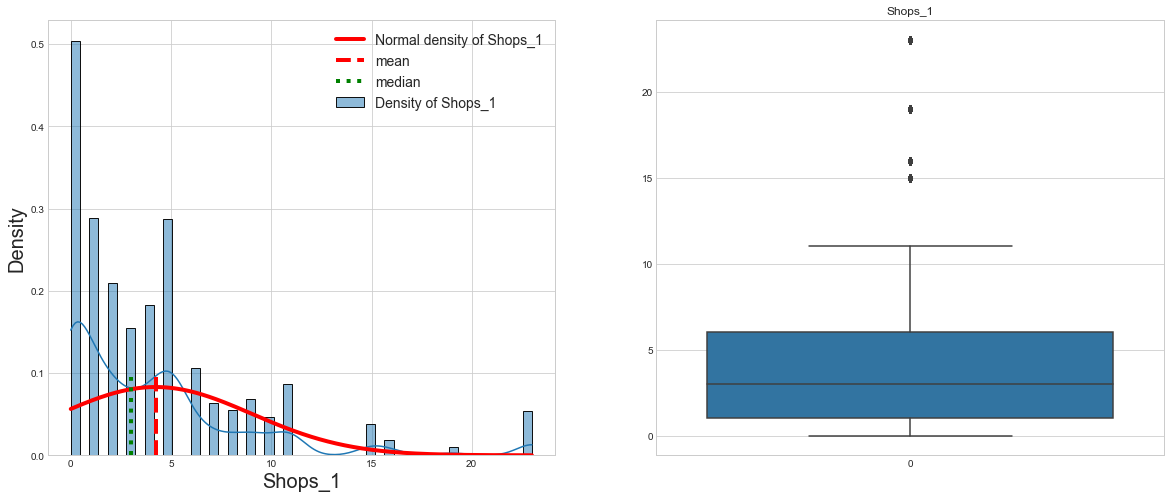

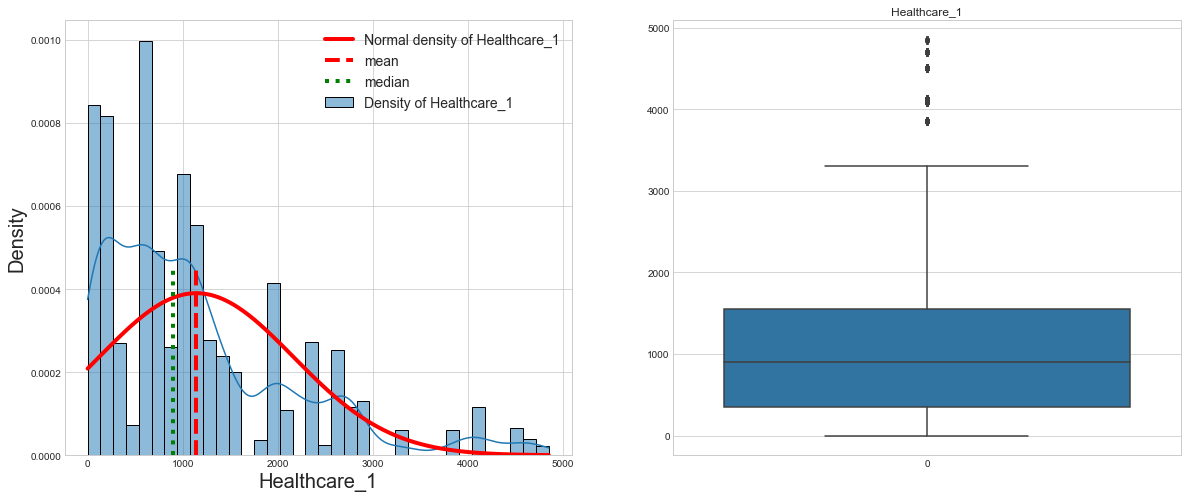

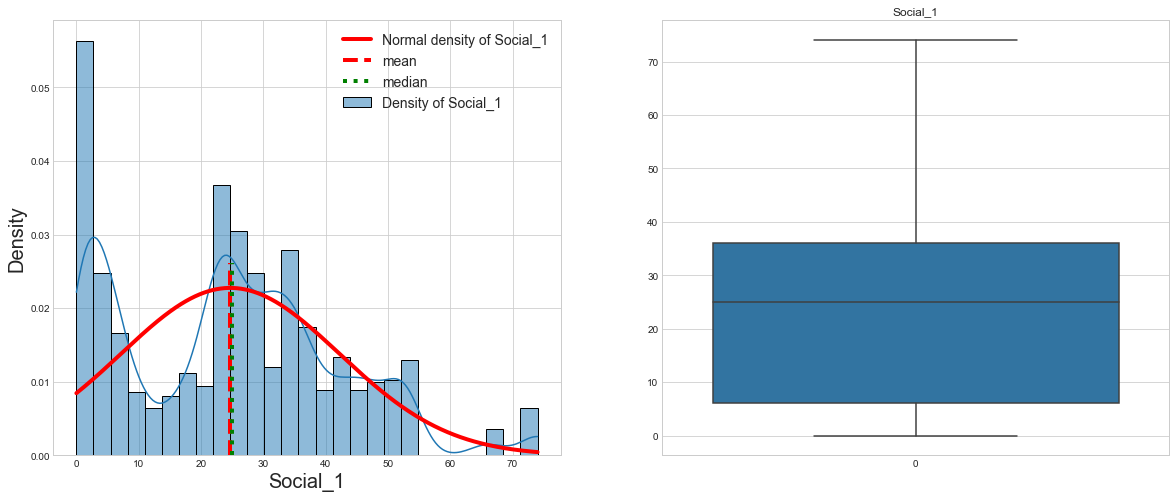

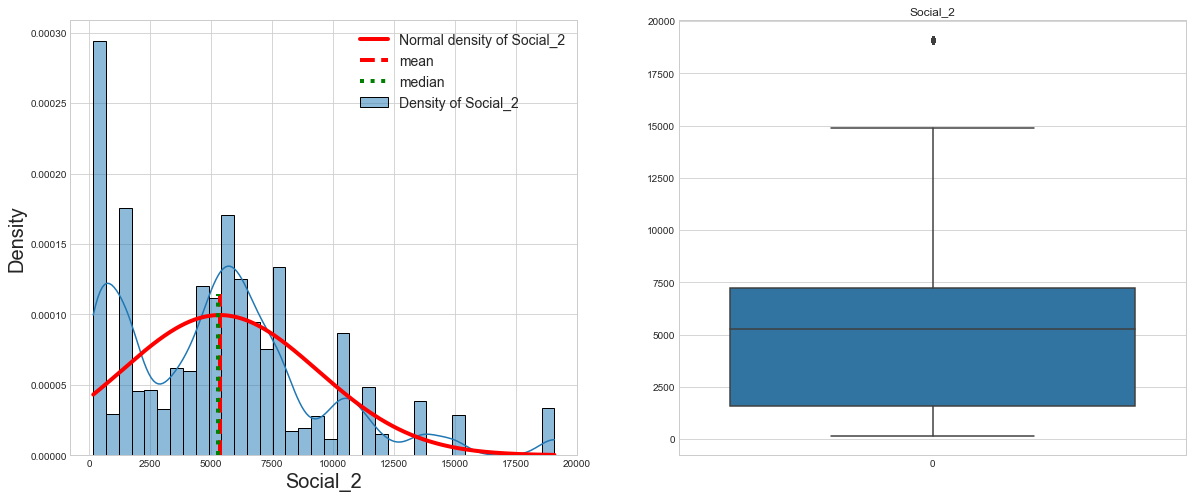

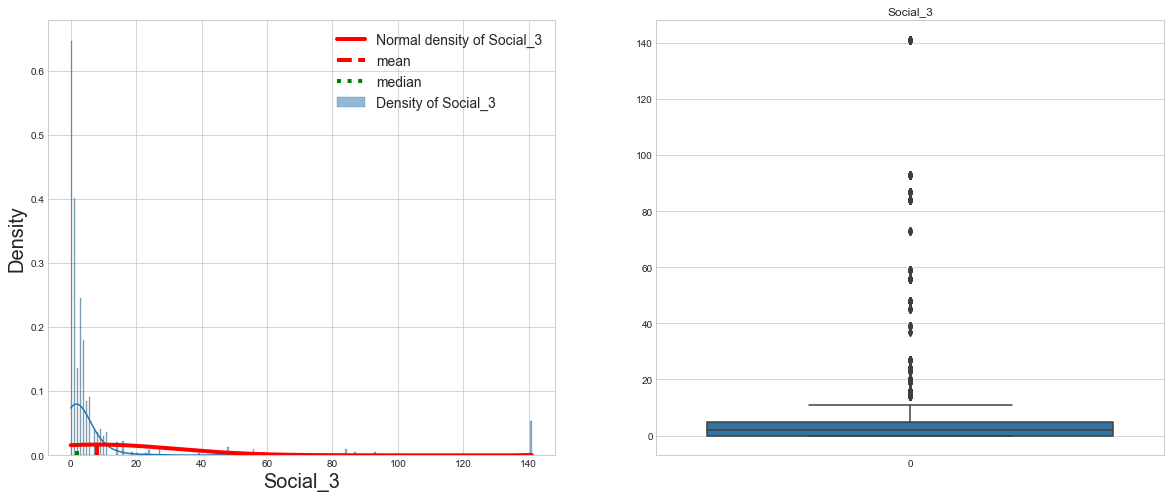

In [7]:
density_hist_plot(df, quantitative_features)

Остальные количественные признаки также своим рапределением явно отличаются от нормального.

При этом у некоторых признаков присутствуют аномальные значения (выбросы), имеющие большое значение и при этом крайне низкое содержание в выборке, что будет учтено при корректировке и подготовке данных в следующих разделах.

В наличии выбросов также можно убедиться при помощи статистических параметров данных, полученных при помощи метода describe():

In [8]:
df[quantitative_features].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Ecology_1,Shops_1,Healthcare_1,Social_1,Social_2,Social_3
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,0.118858,4.231300,1142.904460,24.687000,5352.157400,8.039200
std,0.839512,21.058732,86.241209,28.560917,0.119025,4.806341,1021.517264,17.532614,4006.799803,23.831875
min,0.000000,1.136859,0.370619,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000
25%,1.000000,41.774881,22.769832,1.000000,0.017647,1.000000,350.000000,6.000000,1564.000000,0.000000
50%,2.000000,52.513310,32.781260,6.000000,0.075424,3.000000,900.000000,25.000000,5285.000000,2.000000
75%,2.000000,65.900625,45.128803,9.000000,0.195781,6.000000,1548.000000,36.000000,7227.000000,5.000000
max,19.000000,641.065193,7480.592129,2014.000000,0.521867,23.000000,4849.000000,74.000000,19083.000000,141.000000


Видно, что некоторые признаки содержат данные, значительно превыщающие как средние значение, так и моду, причем некоторые отстоят от среднего больше чем на 3 сигмы (количество комнат, площади и т.д.).
При этом в данных признаков 'LifeSquare' и 'Healthcare_1' содержатся пропуски.

## 3.3 Оценка категориальных признаков

In [9]:
# список категориальных признаков
qualitative_features = [
     'DistrictId',
     'Floor',
     'HouseFloor',
     'HouseYear',
     'Ecology_2',
     'Ecology_3',
     'Helthcare_2',
     'Shops_2']

Статистические параметры категориальных признаков:

In [10]:
df[qualitative_features].describe()

,DistrictId,Floor,HouseFloor,HouseYear,Helthcare_2
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,50.400800,8.526700,12.609400,3.990166e+03,1.319500
std,43.587592,5.241148,6.775974,2.005003e+05,1.493601
min,0.000000,1.000000,0.000000,1.910000e+03,0.000000
25%,20.000000,4.000000,9.000000,1.974000e+03,0.000000
50%,36.000000,7.000000,13.000000,1.977000e+03,1.000000
75%,75.000000,12.000000,17.000000,2.001000e+03,2.000000
max,209.000000,42.000000,117.000000,2.005201e+07,6.000000


Частота встречи конкретного значения во всей выборке каждого признака:

In [11]:
for name in qualitative_features:
    print(name, '\n')
    print(df[name].value_counts())
    print('-' * 20, '\n')

DistrictId 

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64
-------------------- 

Floor 

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
31      1
33      1
42      1
37      1
Name: Floor, dtype: int64
-------------------- 

HouseFloor 

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0   

Видно, что в данных также присутствуют неправдоподобные значения большой величины, встречающиеся в данных не более 1 раза.
Также для некоторых признаков количество одной категории много меньше, чем другой (например Helthcare_2).

Построим гистограммы, используя логарифмический масштаб для оси y, отображающей количество конкретной категории в выборке, чтобы увидеть значения, количество которых невелико.

In [12]:
def hist_plot(data_frame, features_name):
    
    
    if type(features_name) is not list:
        features_name = [features_name]
    
    for name in features_name: 
        plt.figure(figsize=(8,8))
        
        df[name].hist()
        plt.yscale(value="log")
        
        if df[name].dtype in ['float64', 'int64']:
            #медиана и мода среднее значение
            plt.vlines(df[name].mode(), ymin=0, ymax=df[name].value_counts().to_list()[0], label='mode', color='red', linestyle='--', linewidth = 4)
            plt.vlines(df[name].median(), ymin=0, ymax=df[name].value_counts().to_list()[0], label='median', color='green', linestyle=':', linewidth = 4)

            plt.legend(fontsize=14)
            
        plt.xlabel(name, fontsize=20)
        plt.ylabel('Count', fontsize=20)

        plt.show()
        
    return

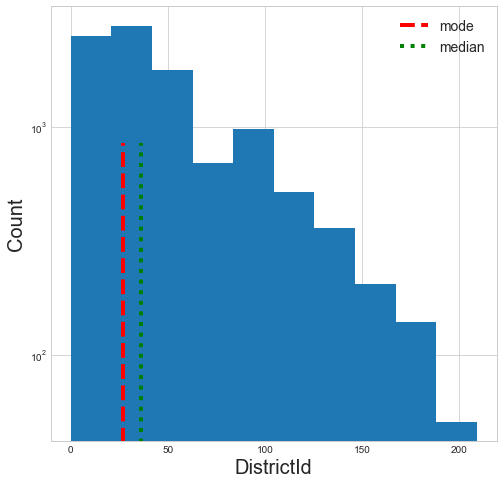

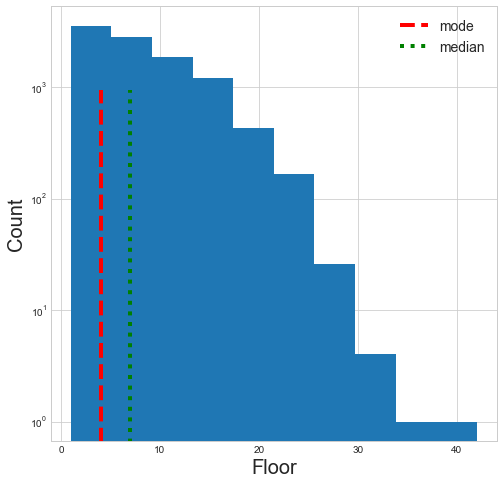

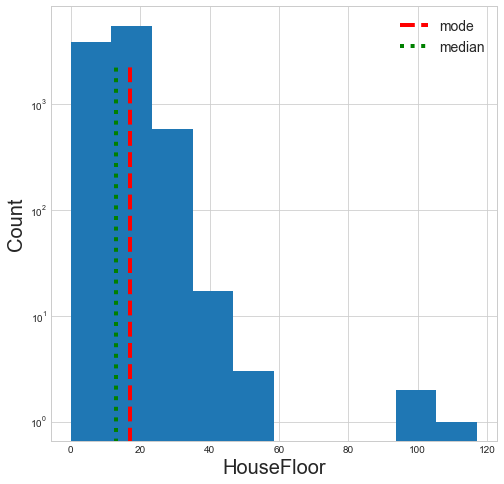

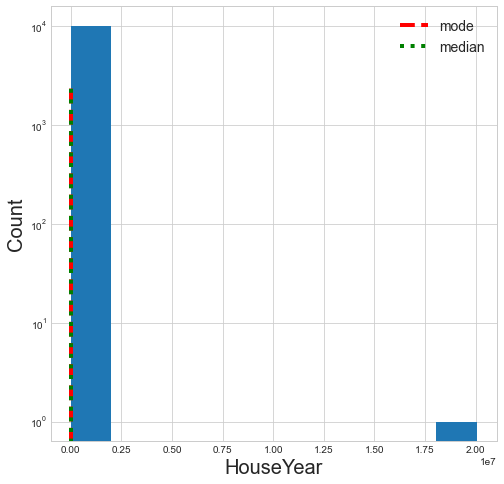

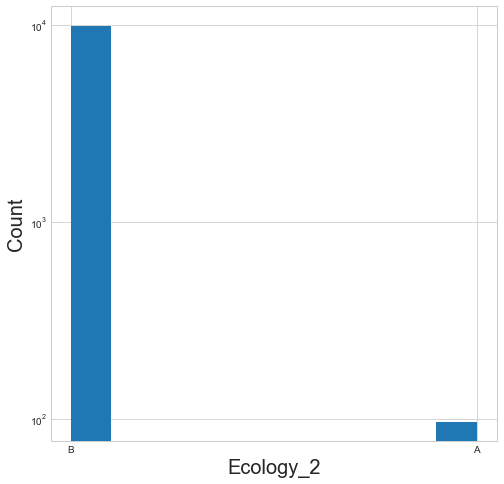

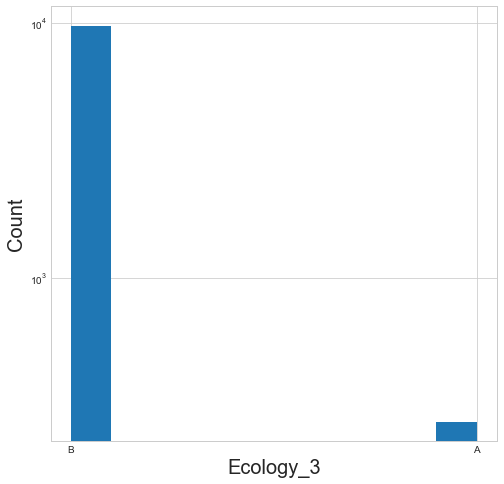

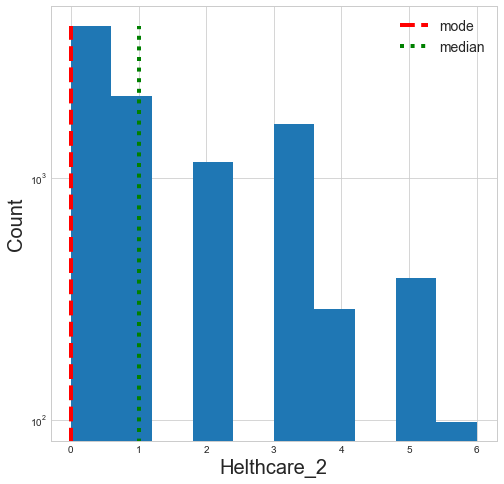

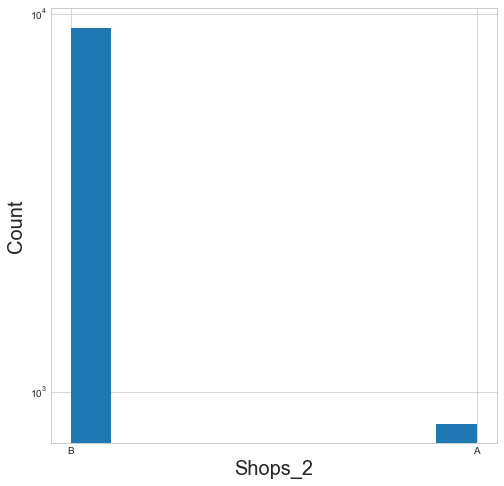

In [13]:
hist_plot(df, qualitative_features)

# 4. Подготовка и очистка данных

## 4.1 Преобразование символьных значений категориальных переменных в числовые

In [14]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


Признаками, соедержащими символьные значения, являются __Ecology_2, Ecology_3, Shops_2__, причем каждый из них может в каждой отельной строке может содержать значение __'A'__ или __'B'__.

Заменим эти значения на 0 и 1 соответственно:

In [15]:
df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B': 1})
df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B': 1})
df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B': 1})

In [16]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,1,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,1,1,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,1,1,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,1,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.102962,1,1,1


## 4.2 Заполнение пропусков

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

С учетом того, что в данных для признака __LifeSquare__ содержатся выбросы и некорректные данные, заполним пропуски средним значением по подвыборке из диапазона с 5 по 95 квантили.

Для параметра __Healthcare_1__ пропуски запоним нулевым значением.

In [18]:
mean_life_square_5_95 = df.loc[
    (df['LifeSquare'] > np.quantile(df.loc[df['LifeSquare'].isnull() == False, 'LifeSquare'], q=.05)) &\
    (df['LifeSquare'] < np.quantile(df.loc[df['LifeSquare'].isnull() == False, 'LifeSquare'], q=.95)), 'LifeSquare'].mean()

In [19]:
df['LifeSquare'] = df['LifeSquare'].fillna(mean_life_square_5_95)
   
df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_1'].mean())

## 4.3 Отчистка от выбросов

__Rooms__:

выбросами будем считать значения равные или превышающие 5 ввиду того, что их количество очень мало, а также нулевые значения.

Заменим их на моду (не на среднее, так как количество комнат - целое число);

In [20]:
df.loc[(df['Rooms'] < 1) | (df['Rooms'] >= 5), 'Rooms']

403      5.0
505      5.0
511      5.0
940      5.0
1459     5.0
1906     5.0
1909     5.0
2004    10.0
2194     0.0
2516     5.0
2728    10.0
2799     5.0
3780     0.0
5665     5.0
5737     5.0
5894     0.0
6088    19.0
6290     5.0
6401     0.0
7644     0.0
7929     0.0
7975     5.0
8532     5.0
8794     6.0
9307     5.0
9415     5.0
9515     5.0
9641     5.0
9767     0.0
9869     0.0
Name: Rooms, dtype: float64

In [21]:
df.loc[(df['Rooms'] < 1) | (df['Rooms'] >= 5), 'Rooms'] = df['Rooms'].mode()[0]

__Square__:


в данных присутствуют крайне экстремальные аномальные значения, отстоящие от среднего на расстоянии гораздо большем чем 3 сигмы (следовательно крайне маловероятны), при этом их количество отночительно размера выборки невелико.

Также в выборке присутствуют значения меньшие, чем самое возможное наименьшее значение - средняя площадь квартир студий в Москве, которая составляет около 23 кв. м., а некоторые вообще неадекватно маленькие (площадь меньше 6 кв. м.).

Заменим эти значения на среднее значения площади, рассчитанное по всей выборке.

In [22]:
df.loc[(df['Square'] > df['Square'].mean() + df['Square'].std() * 3) | (df['Square'] < 23), 'Square']

136     119.914990
161       2.954309
286     123.430072
299      20.924926
328       4.390331
           ...    
9767    138.427694
9846    148.671938
9869      2.377248
9877    122.181937
9990     18.983962
Name: Square, Length: 121, dtype: float64

In [23]:
df.loc[(df['Square'] > df['Square'].mean() + df['Square'].std() * 3) | (df['Square'] < 23), 'Square'] = df['Square'].mean()

__LifeSquare__:

с этим признаком ситуация аналогична ситуации с признаком __Square__.

При этом наименьшее возможное значение жилой площади - средняя жилая площадь квартир-студий, которая составляет около 14 кв. м.

In [24]:
df.loc[(df['LifeSquare'] > df['LifeSquare'].mean() + df['LifeSquare'].std() * 3) | (df['LifeSquare'] < 14), 'LifeSquare']

26       4.769174
119      0.795539
161      5.257278
212      3.064320
227      1.944446
          ...    
9912     5.600609
9915    12.125029
9938     2.637095
9982     1.855415
9990    11.419796
Name: LifeSquare, Length: 236, dtype: float64

In [25]:
df.loc[(df['LifeSquare'] > df['LifeSquare'].mean() + df['LifeSquare'].std() * 3) | (df['LifeSquare'] < 14), 'LifeSquare'] = df['LifeSquare'].mean()

__KitchenSquare__:

Если жилая площадь может быть довольно большой за счет наличия нескольких спален, гостиных и т.д., то площадь кухни, превышающая 40 кв. м., выглядит слегка недостоверно и неправдоподобно. Будем считать все значения площади, превышающие 40 кв. м. выбросами.

При этом в качестве минимальной разумной площади примем среднюю площадь кухонь, которая составляет около 6 кв. м.
Нулевое значение допускается, так как кухня может быть совмещена с жилой комнатой, как в квартирах студиях.

In [26]:
df.loc[(df['KitchenSquare'] > 40) | ((df['KitchenSquare'] < 6) & (df['KitchenSquare'] > 0)), 'KitchenSquare']

3       1.0
8       1.0
9       1.0
13      5.0
17      5.0
       ... 
9983    1.0
9989    5.0
9990    2.0
9997    5.0
9998    5.0
Name: KitchenSquare, Length: 3721, dtype: float64

In [27]:
df.loc[(df['KitchenSquare'] > 40) | ((df['KitchenSquare'] < 6) & (df['KitchenSquare'] > 0)), 'KitchenSquare'] = df['KitchenSquare'].mean()

__KitchenSquare__, __LifeSquare__ и __Square__:

Так же очевидно, что признаки __KitchenSquare__, __LifeSquare__ и __Square__ связаны следующим соотношением:

$$Square=LifeSquare + KitchenSquare + OtherSquare$$, где __OtherSquare__ - нежилая площадь за исключением площади кухни.

При этом можно допустить, что __OtherSquare__ может быть и равной нулю, но в любом случае сумма жилой площади __LifeSquare__ и площади кухни __KitchenSquare__ не должна превышать общей площади __Square__.

Проверим, выполняется ли это условия на данных.

In [28]:
df.loc[df['LifeSquare'] + df['KitchenSquare'] > df['Square'], ['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
3,40.409907,34.753140,6.2733
8,46.887892,44.628132,6.2733
9,79.867477,75.085125,6.2733
19,42.367289,40.012529,6.2733
33,73.314975,74.131261,6.2733
...,...,...,...
9978,39.314342,34.753140,6.2733
9979,40.043234,41.984322,6.2733
9982,36.112393,36.682698,6.2733
9987,62.690057,64.602939,10.0000


Определим среднее значение другой площади __OtherSquare__:

In [29]:
mean_other_square = (
df.loc[df['LifeSquare'] + df['KitchenSquare'] < df['Square'], 'Square'] -\
df.loc[df['LifeSquare'] + df['KitchenSquare'] < df['Square'], 'LifeSquare'] -\
df.loc[df['LifeSquare'] + df['KitchenSquare'] < df['Square'], 'KitchenSquare']).mean()

Заменим значения по следующему принципу:

если разница меньше между __LifeSquare__ и __KitchenSquare__ меньше __OtherSquare__, то в __Square__ записываем значение суммы __LifeSquare__ и __KitchenSquare__,

в противном случае записываем сумму __OtherSquare__, __LifeSquare__ и __KitchenSquare__.
    

In [30]:
df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] < mean_other_square, 'Square'] =\
df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] < mean_other_square, 'LifeSquare'] +\
df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] < mean_other_square, 'KitchenSquare']

df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] > mean_other_square, 'Square'] =\
df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] > mean_other_square, 'LifeSquare'] +\
df.loc[df['Square'] - df['LifeSquare'] - df['KitchenSquare'] > mean_other_square, 'KitchenSquare'] +\
mean_other_square

__HouseFloor__:

В выборке есть несколько больших значений, причем для самых больших значений, значение смежного признака __Floor__ гораздо меньше (например квартира располагается на 5 этаже, а количество этажей в доме - 99).

Заменим эти значения на самый большой этаж, на котором располагается квартира.

In [31]:
df.loc[df['HouseFloor'] > df['Floor'].max(), ['HouseFloor', 'Floor']]

,HouseFloor,Floor
646,45.0,5
746,99.0,5
765,44.0,31
1678,117.0,8
4657,99.0,6
4987,48.0,42
5031,48.0,22
5259,47.0,22


In [32]:
df.loc[df['HouseFloor'] > df['Floor'].max(), 'HouseFloor'] = df['Floor'].max()

__HouseYear__:

Данные содержат несколько значений дат, которые превышают самую последнюю уже прошедшую дату.

Заменим эти значения модой.

In [33]:
df.loc[df['HouseYear'] > np.quantile(df['HouseYear'], q=.95), 'HouseYear'].value_counts()

2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, dtype: int64

In [34]:
df.loc[df['HouseYear'] > 2018, 'HouseYear'] = df['HouseYear'].mode()[0]

При этом принято решение оставить цену неизменной, так как оценить ее адекватность и правдоподобность не представляется возможным.

То же самое касается и социальных признаков, конкретный смысл которых неизвестен, поэтому оценить их правдоподобность вообще не представляется возможным.

## 4.4 Повторный обзор после обработки данных

In [35]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.883000,48.543150,36.544458,7.189795,8.526700,12.588300,1984.450300,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.800234,17.917235,15.252054,2.943119,5.241148,6.591627,18.105522,0.119025,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,1.000000,20.057882,14.057882,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,34.753140,27.817111,6.273300,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,44.598733,34.753140,6.273300,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,56.483866,41.415441,9.000000,12.000000,17.000000,1999.250000,0.195781,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,4.000000,269.815320,263.542020,40.000000,42.000000,42.000000,2018.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


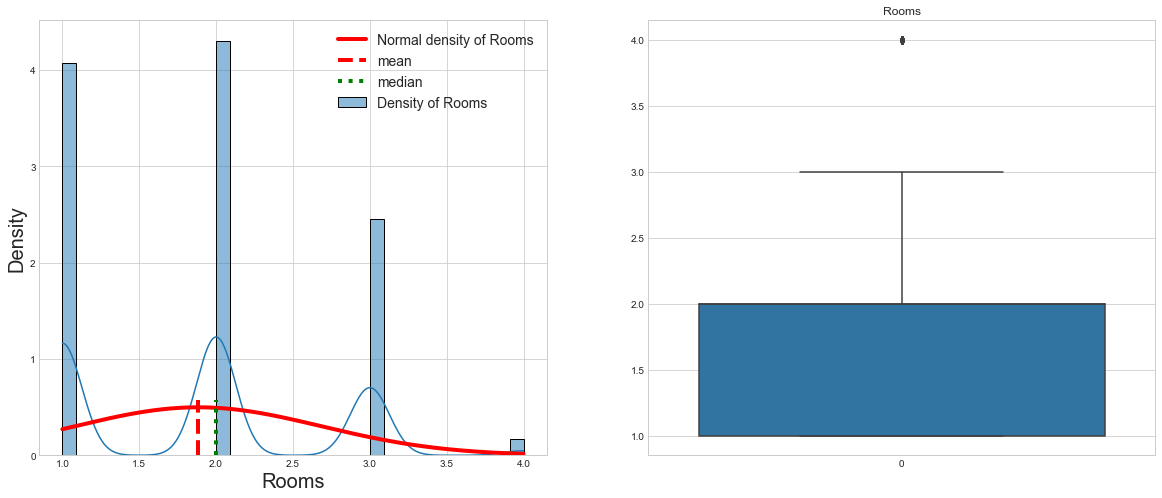

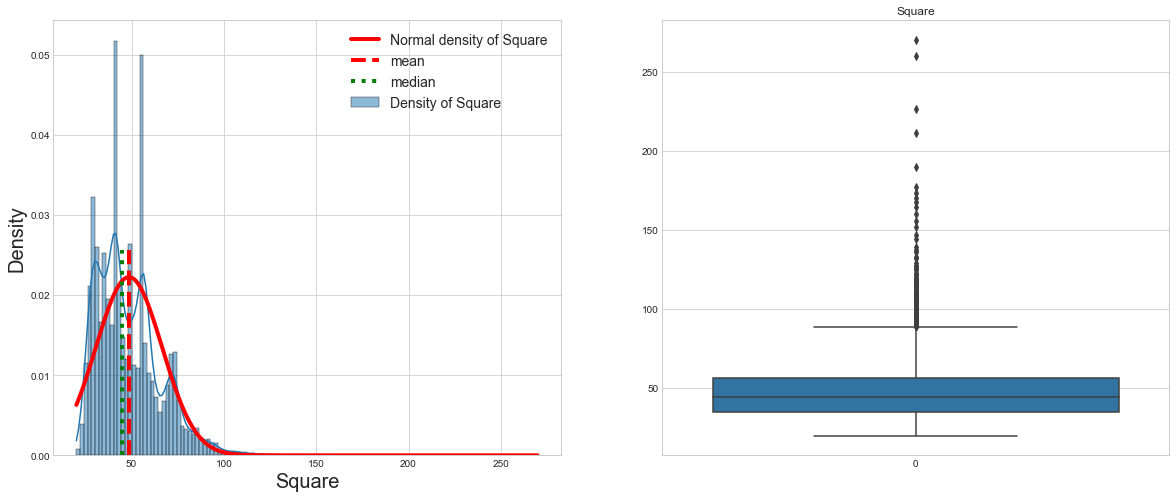

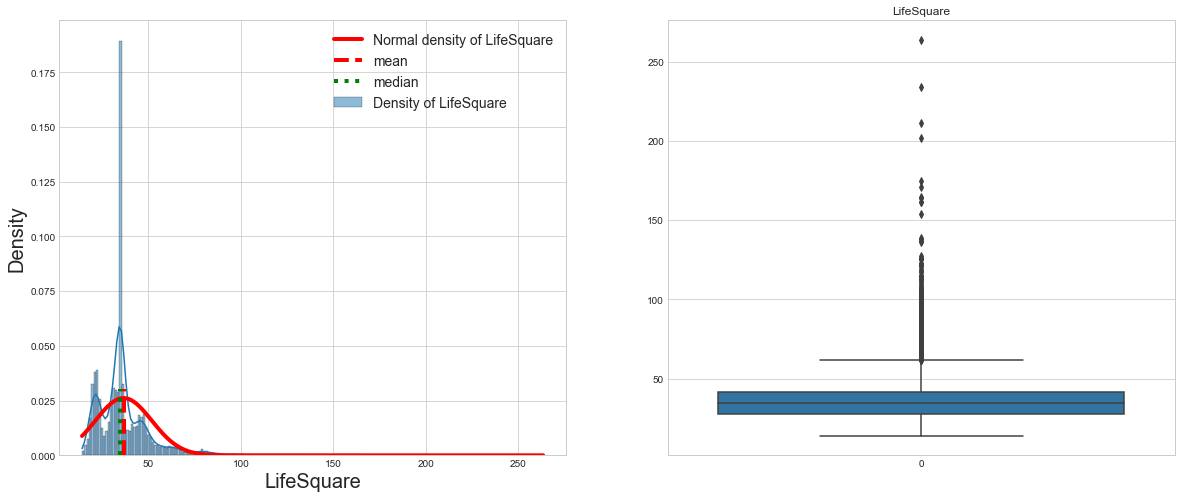

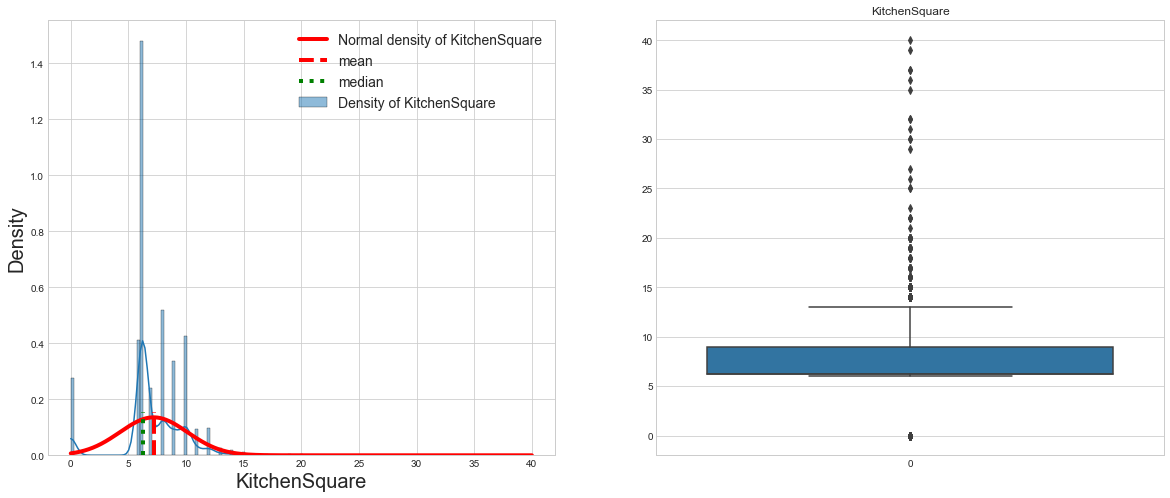

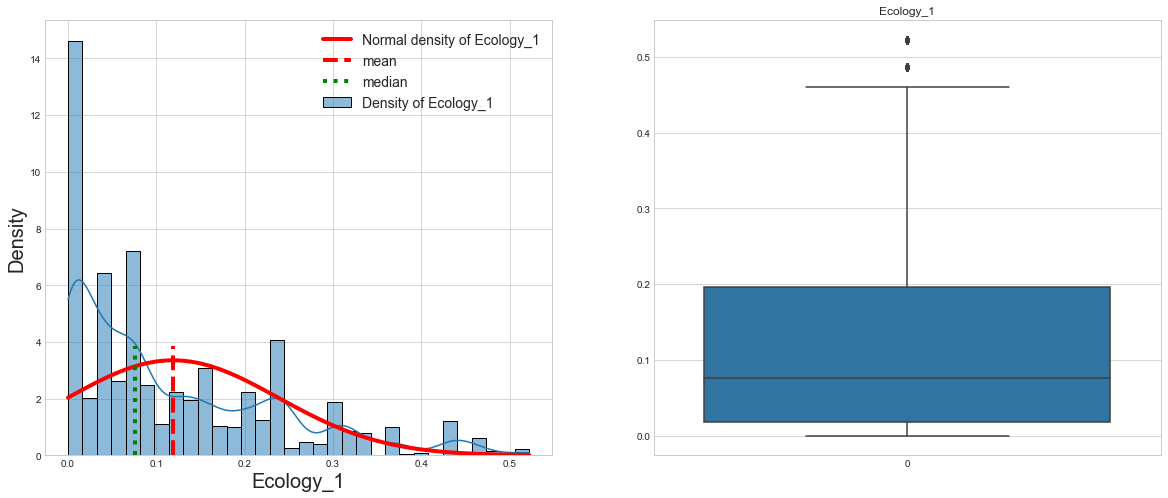

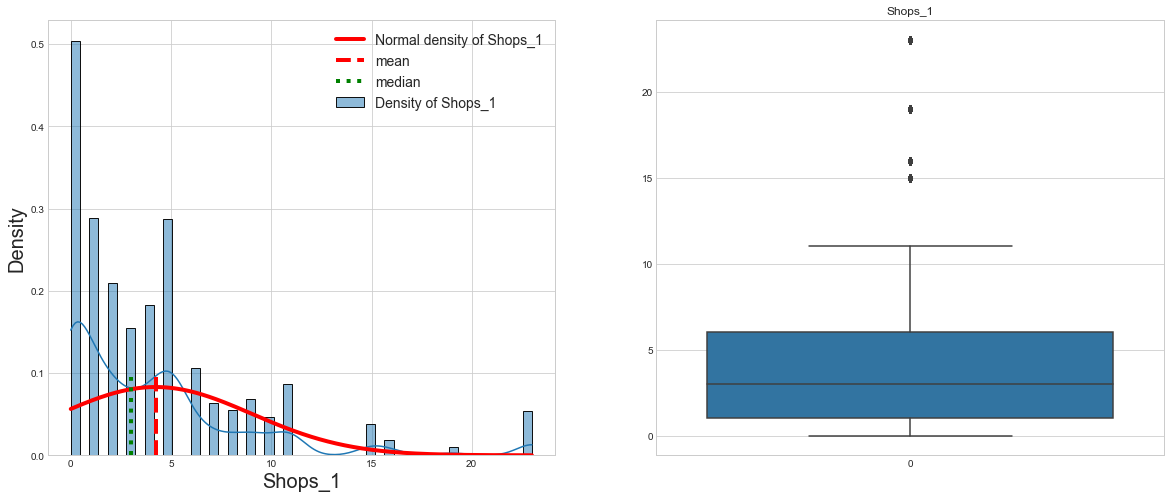

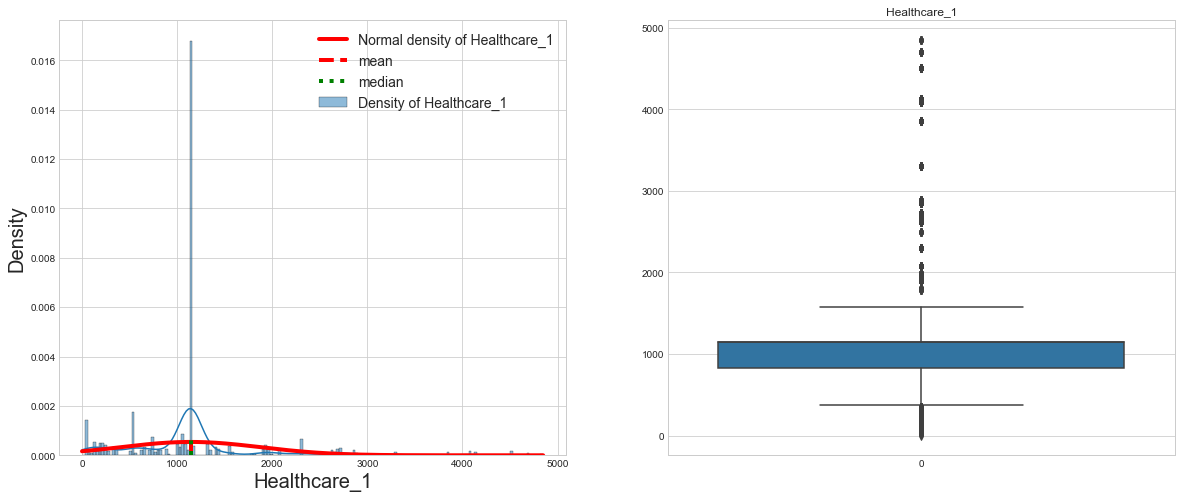

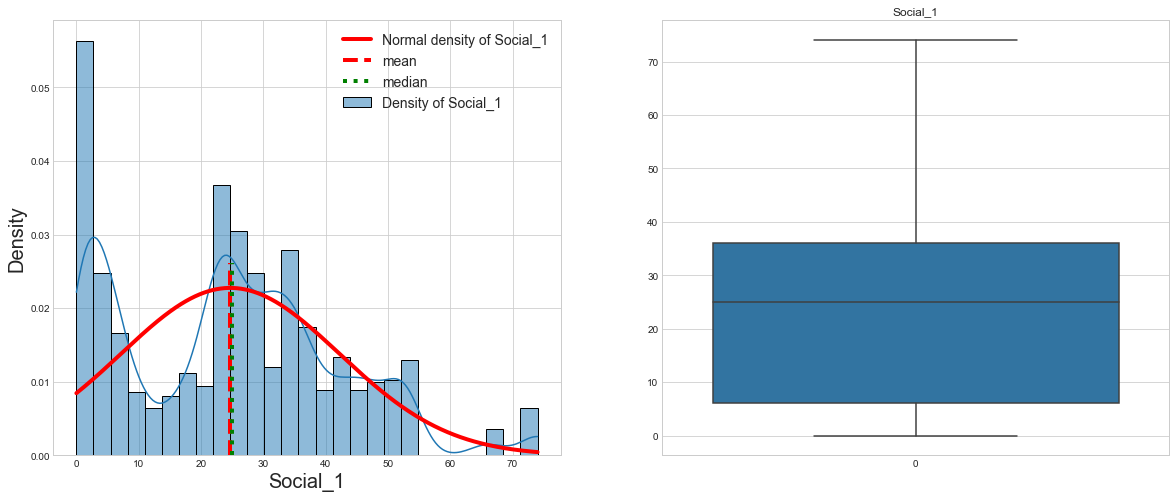

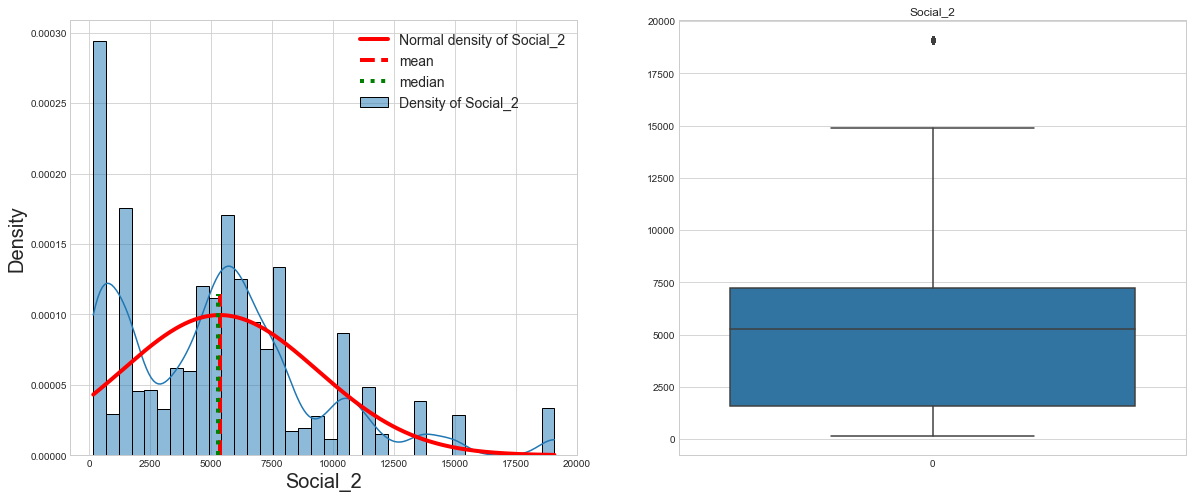

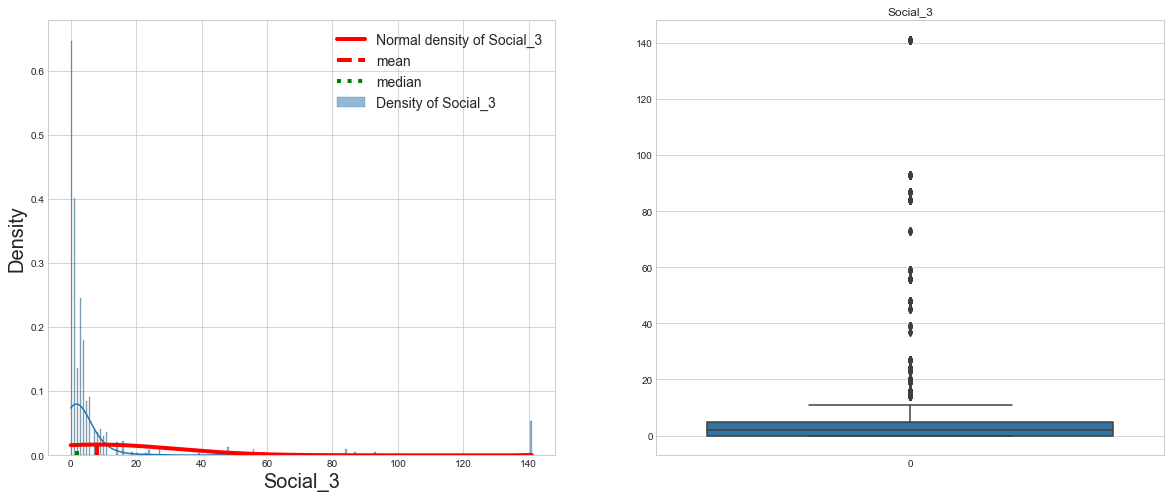

In [36]:
density_hist_plot(df, quantitative_features)

In [37]:
qualitative_features = [
     'DistrictId',
     'Floor',
     'HouseFloor',
     'HouseYear',
     'Ecology_2_bin',
     'Ecology_3_bin',
     'Helthcare_2',
     'Shops_2_bin']


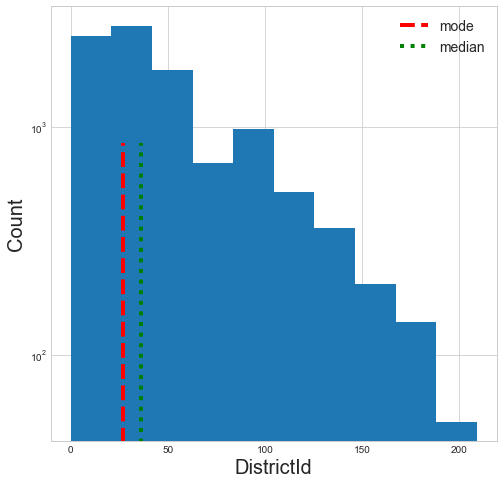

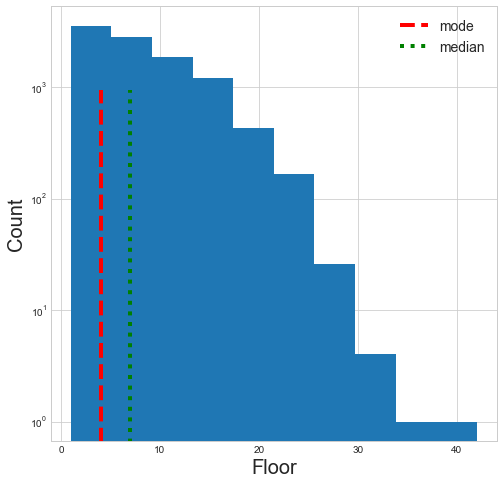

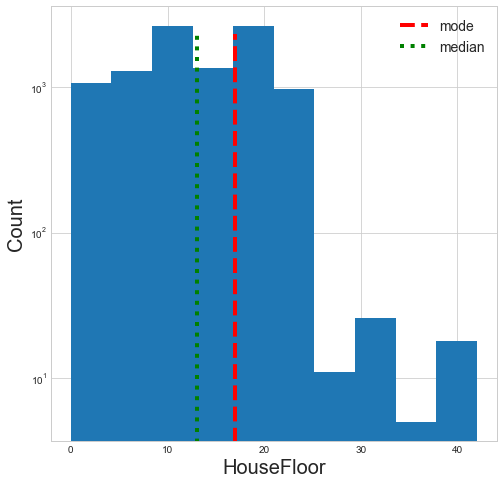

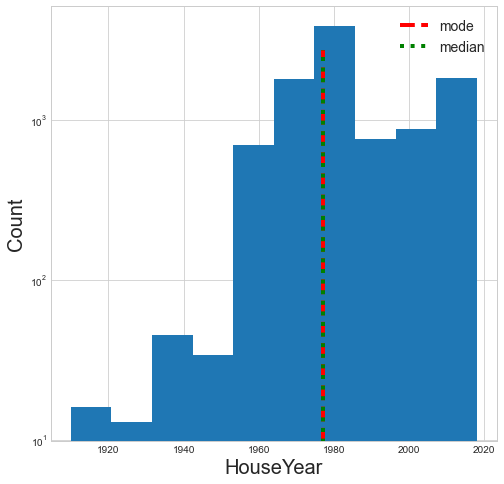

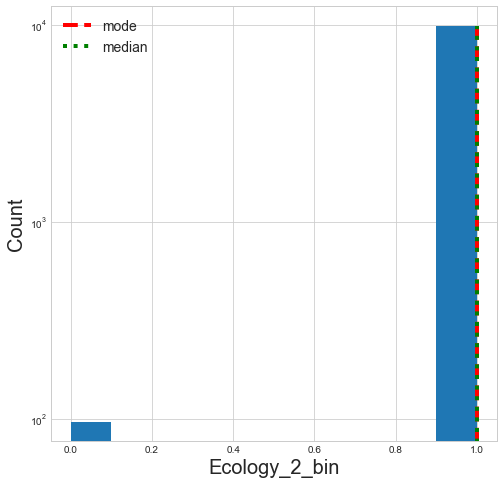

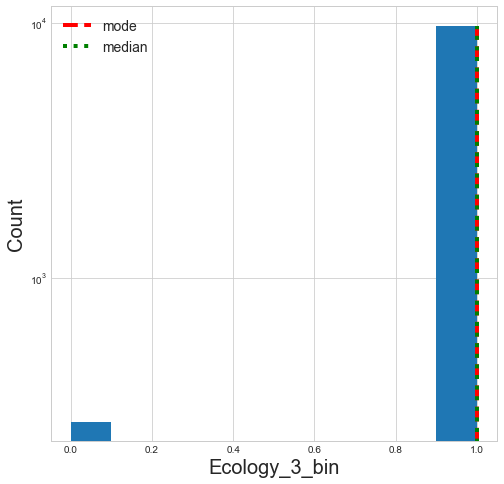

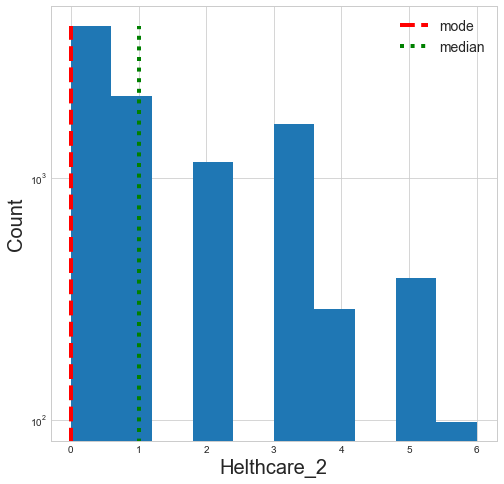

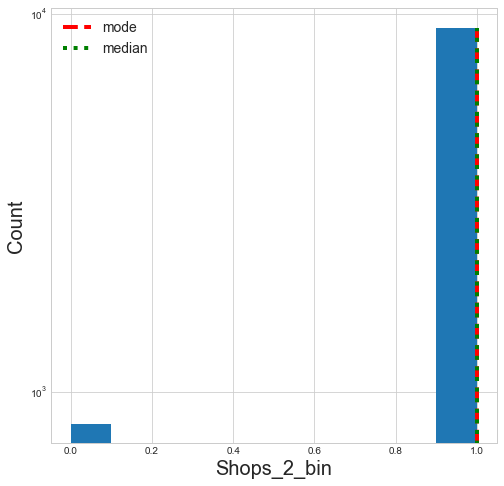

In [38]:
hist_plot(df, qualitative_features)

# 5. Проверка гипотез

## 5.1 Проверка на нормальность

В п. 3.1 была проведена проверка соответствия распределения значений цены нормальному распределению путем построения графика действительной плотности распределения цены и графика плонотсти нормального распределения с параметрами, определенными по имеющейся выборке, а затем их визуальная оценка. В результате был сделан вывод о не соответствии фактического распределения нормальному.

Подтвердим это, проведя оценку на "нормальность" при помощи квантиль-квантильной кривой и проверки ггипотезы о том, что данные в выборке имеют нормальное распределение.

Text(0, 0.5, 'квантили выборки')

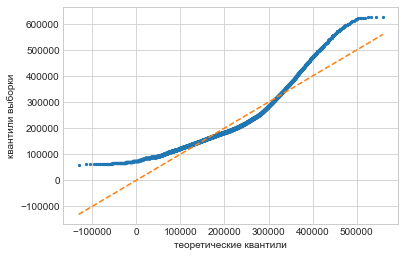

In [39]:
loc = df['Price'].mean()
scale = df['Price'].std()

interval = np.linspace(0, 1, df['Price'].shape[0])[1:-1]
x = stats.norm.ppf(interval, loc=loc, scale=scale)
y = np.quantile(df['Price'], interval)

plt.scatter(x, y, s=5)
plt.plot(x, x, color='C1', linestyle='dashed')

plt.xlabel('теоретические квантили')
plt.ylabel('квантили выборки')

Видно, что фактические квантильные значения выборки сильно отличаются от квантильных значений нормального распределения, полученного с вычесленными по выборке математическими ожиданиями и СКО, что не позволяет принять нормальное распределение за распределение значений выборки.
Данный вывод также подтверждается значением коэффициента детерминации, который был бы близок к 1, если бы распределение действительно было нормальным.

In [40]:
r2(x, y)

0.8976715428507097

Так же проверим нулевую гипотезу о том, что распределение значений соответствует нормальному.

Уровень значимости $\alpha = 0.05$ 

In [41]:
stat, p = stats.normaltest(df['Price'])
print(f'Stats: {stat}, p-value: {p}')

Stats: 2374.7689544862073, p-value: 0.0


Полученное p-значение также явно намекает на то, что распределение не является нормальным.

Для для нормально распределенных значений с вычесленных по выборке МО и СКО, значение статистики и p-значение соответственно равны:

In [42]:
stat, p = stats.normaltest(x)
print(f'Stats: {stat}, p-value: {p}')

Stats: 0.14429178045840696, p-value: 0.9303951503477441


## 5.2 Проверка гипотез о математическом ожидании / среднеквадратическом отклонении

Предположим, что мы дополняем датасет (для уточнения интерполирующих, экстраполирующих моделей) данными о квартирах из других районов, для которых до настоящего момента у нас не было никаких данных.

Но при этом вновь добавляемые данные не содержат сведения о всей выборке (о всех квартирах в данном районе), а о нескольких объектах.

В таком случае проверим 2 гипотезы:

${H_0}_\mu$ - гипотеза о том, что математическое ожидание цены новых данных равно математическому ожиданию цены уже имеющюйся выборки;
    
${H_0}_\sigma$ - гипотеза о том, что среднеквадратическое отклонение цены новых данных равно среднеквадратическому отклонению цены уже имеющюйся выборки.

Для этого разобъем датасет на две части: большую, которую будем считать как уже имеющиеся данные, и меньшую, содержащую только полученные новые данные.

Размер новой выборки примем равный 20.

Уровень значимости $\alpha$ примем равным 0.05.

Обе гипотезы двусторонние.

In [43]:
alpha = .05
n = 20
list_of_district_id = df['DistrictId'].value_counts()
list_of_district_id = list_of_district_id[list_of_district_id > 20].index

random_chose_district_id = rnd.choice(list_of_district_id)
random_chose_district_id

98

In [44]:
new_data = df.loc[df['DistrictId'] == random_chose_district_id].sample(n=20, replace=False)

In [45]:
old_data = df.drop(df.loc[df['DistrictId'] == random_chose_district_id].index)

Для проверки гипотезы ${H_0}_\mu$ воспользуемся __Z__ статистикой:
$$Z = \dfrac{\overline{X} - \mu}{\sigma / \sqrt{n}},$$

In [46]:
old_data_mean = old_data['Price'].mean()
new_data_mean = new_data['Price'].mean()
old_data_std = old_data['Price'].std()
new_data_std = new_data['Price'].std()

In [47]:
z = (new_data_mean - old_data_mean) * np.sqrt(n) / (old_data_std)

p_left = stats.norm.cdf(z)
p_right = 1 - stats.norm.cdf(z)

p_value = 2 * min(p_left, p_right)

if alpha < p_value:
    print('Нулевую гипотезу можно принять, так как уровень значимости меньше p-value')
else:
    print('Нулевую гипотезу нельзя принять, так как p-value больше уровеня значимости')

Нулевую гипотезу можно принять, так как уровень значимости меньше p-value


Для проверки гипотезы ${H_0}_\sigma$ воспользуемся следующей статистикой:

$$H = \dfrac{(n - 1) S^2}{\sigma^2},$$

где: n - число элменетов в выборке, $S^2$ - несмещенная оценка дисперсии, $\sigma^2$ - утверждаемая нулевой гипотезой дисперсия.

In [48]:
h = (n - 1) * new_data_std ** 2 / old_data_std ** 2


p_left = stats.chi2.cdf(h, df=n-1)
p_right = 1 - stats.chi2.cdf(h, df=n-1)

p_value = 2 * min(p_left, p_right)

if alpha < p_value:
    print('Нулевую гипотезу можно принять, так как уровень значимости меньше p-value')
else:
    print('Нулевую гипотезу нельзя принять, так как p-value больше уровеня значимости')

Нулевую гипотезу можно принять, так как уровень значимости меньше p-value


# 6 Корреляционный анализ

Построим матрицу корреляции для данных:

In [49]:
features = [
    'Price',
    'DistrictId',
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_2_bin',
    'Ecology_3_bin',
    'Helthcare_2',
    'Shops_2_bin',
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Ecology_1',
    'Shops_1',
    'Healthcare_1',
    'Social_1',
    'Social_2',
    'Social_3']

### Коэффициент корреляции Пирсона

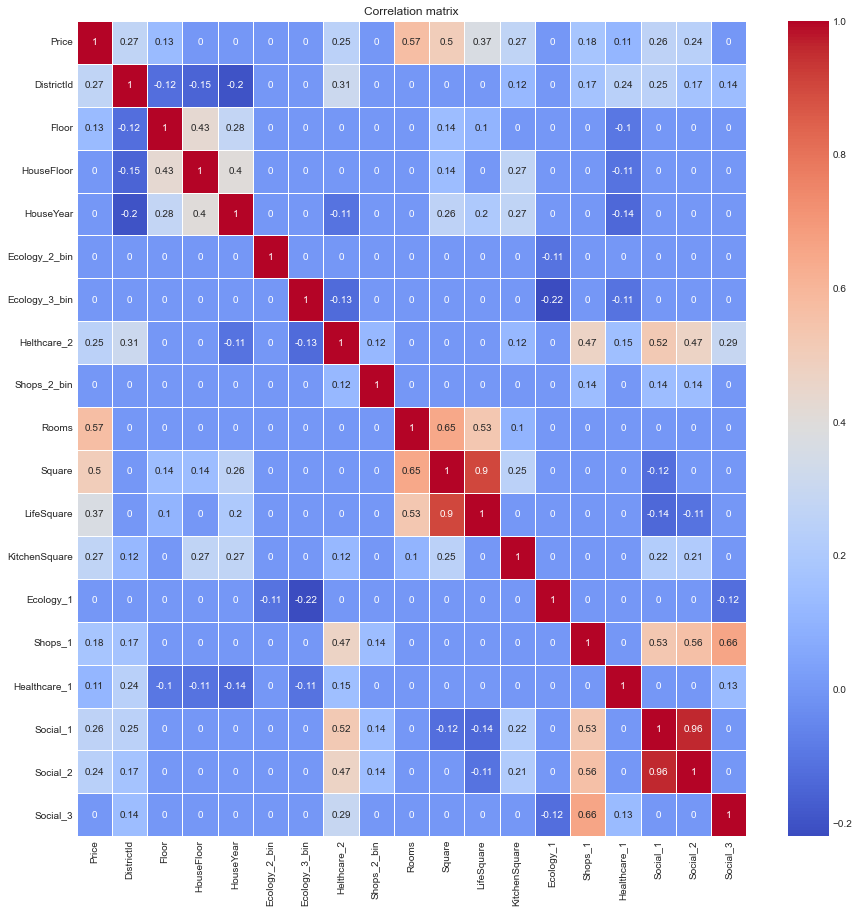

In [50]:
plt.figure(figsize=(15, 15))

# sns.set(font_scale=1.4)

corr_matrix = df[features].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < .1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.6, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Как видно из корреляционной матрицы, довольно большая корреляция между такими признаками, как 'Square', 'LifeSquare', 'KitchenSquare' и 'Rooms', причина которой очевидна.

Также довольно высокая корреляция между:
 - парой признаков 'Social_1' и 'Social_2' - 0.96;
 - 'Shops_1' и 'Social_1', 'Social_2', 'Social_3' и 'Helthcare_2'.

In [51]:
corr_feature_list = ['Shops_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2']

### Коэффициент корреляции Кендалла

Проверим данные на предмет наличия нелинейной зависимости при помощи коэффициента корреляции Кендалла:

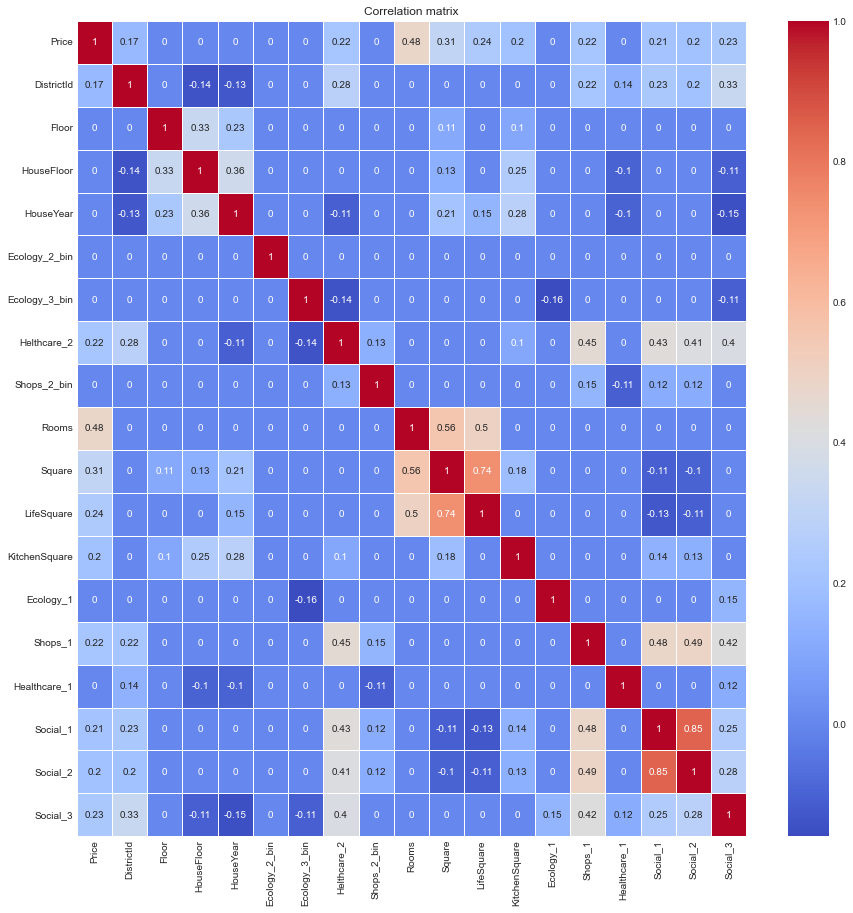

In [52]:
plt.figure(figsize=(15, 15))

# sns.set(font_scale=1.4)

corr_matrix = df[features].corr(method='kendall')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < .1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.6, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Наличия какой-либо дополнительной зависимости не обнаружено.

Рассмотрим графики зависимости рассеяния одних коррерилующих параметров от других:

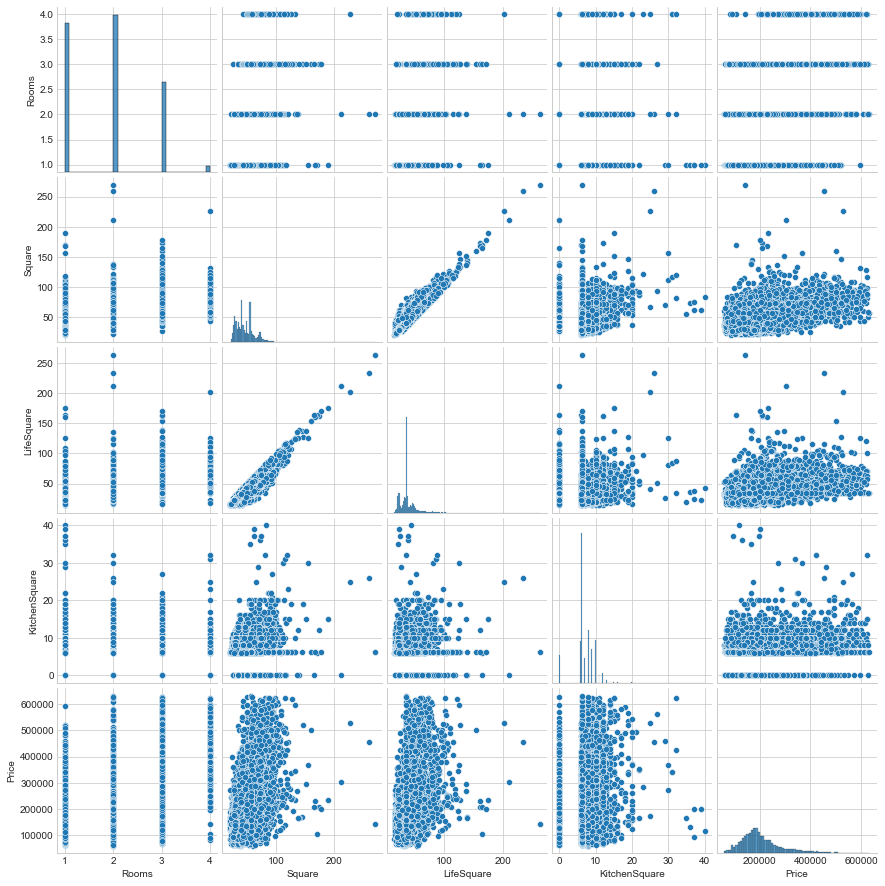

In [53]:
sns.pairplot(df[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Price']])

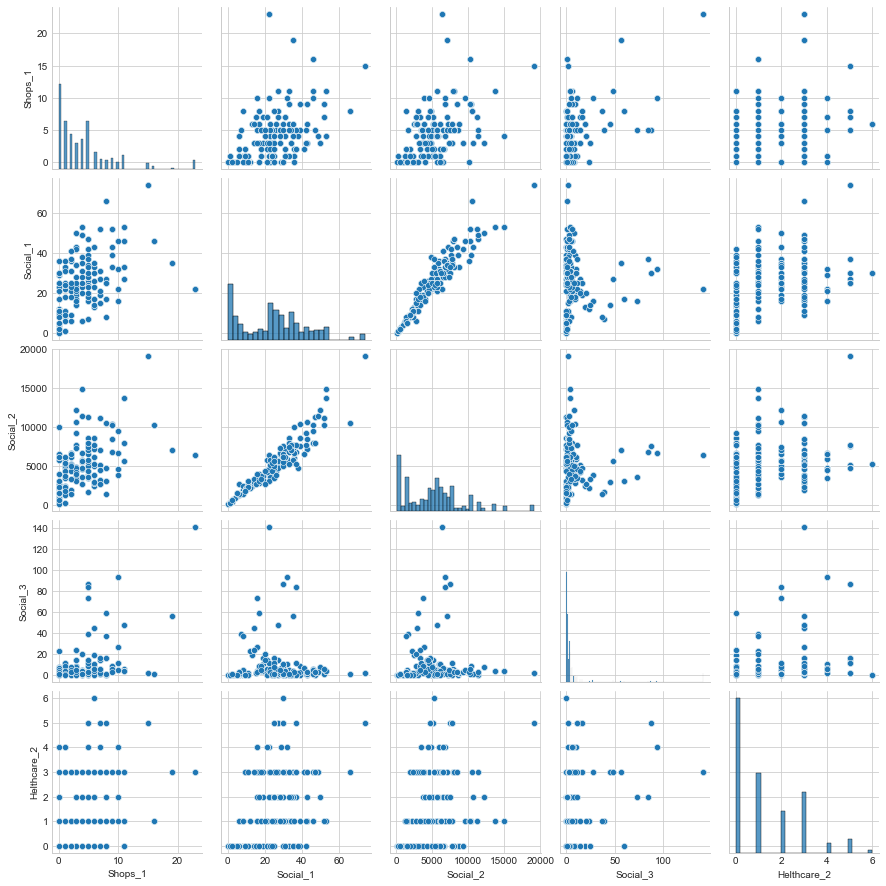

In [54]:
sns.pairplot(df[corr_feature_list])

Видно, что для таких пар признаков, как 'Social_1' и 'Social_2' и 'Square' и 'LifeSquare', значения располагаются практически вдоль прямой.

При помощи факторного анализа сведем каждую пару признаков в отдельный признак.

In [55]:
pca = PCA(n_components=1)
df['Social_1_2'] = pca.fit_transform(df[['Social_1', 'Social_2']])
pca.explained_variance_ratio_

array([0.99999835])

In [56]:
df['SquareLifeSquare'] = pca.fit_transform(df[['Square', 'LifeSquare']])
pca.explained_variance_ratio_

array([0.95014823])

In [57]:
df[['Social_1', 'Social_2', 'Social_1_2', 'Square', 'LifeSquare', 'SquareLifeSquare']].head()

,Social_1,Social_2,Social_1_2,Square,LifeSquare,SquareLifeSquare
0,11,3097,-2255.194923,59.975984,34.753140,7.623020
1,30,6207,854.857346,31.169223,23.169223,-21.908332
2,33,5261,-91.121828,72.894816,47.671972,25.820456
3,1,264,-5088.211968,41.026440,34.753140,-6.916070
4,33,8667,3314.848372,62.785361,38.562517,12.221647


Видно, что при уменьшении размерности потеряна относительно небольшая часть информации.

# 7. Регрессионный анализ

Построим линейную модель по полученным на всех предыдущих этапах данным:

In [58]:
features = [
    'DistrictId',
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_2_bin',
    'Ecology_3_bin',
    'Helthcare_2',
    'Shops_2_bin',
    'Rooms',
    'SquareLifeSquare',
    'KitchenSquare',
    'Ecology_1',
    'Shops_1',
    'Healthcare_1',
    'Social_1_2',
    'Social_3']

target = ['Price']

In [59]:
model = LinearRegression().fit(df[features], df[target])

r2_price = r2(df['Price'], model.predict(df[features]))
r2_price

0.49142005644096487

Как видно, коэффициент детерминации довольно низок (скорее всего из-за манипуляций с данными).
Требуются дополнительные исследования...

Проверим уровень значимости получившегося уравнения регрессии, используюя критерий Фишера.
Уровень значимости 0.05

In [60]:
m =  len(features)
n = df.shape[0]
alpha = .05

k1 = m
k2 = n - m - 1

f = r2_price * k2 / (1 - r2_price) / k1

t = stats.f.ppf(1-alpha, k1, k2)

if f > t:
    print(f'F = {f:.2f} > t = {t:.2f} - значение критерия попадает в критическую область, уравнение регрессии признается значимым')
else:
    print(f'F = {f:.2f} < t = {t:.2f} - значение критерия не попадает в критическую область, уравнение регрессии не признается значимым')


F = 602.89 > t = 1.64 - значение критерия попадает в критическую область, уравнение регрессии признается значимым


# 8. Диспресионный анализ

Проверим нулевую гипотезу, утверждающую, что среднее значение цены одинаково для квартир независимо от этажа их расположения.
Уровень значимости примем равным 0.05.

In [108]:
stats.f_oneway(
    *[df.loc[df['Floor'] == num, 'Price'] for num in df['Floor'].value_counts().index]
)

F_onewayResult(statistic=7.820923746765448, pvalue=3.7473296760976517e-35)

Так как значение p-value гораздо меньше принятого уровня значимости, то основания считать нулевую гипотезу о равенстве средних значений статистически значимой отсутствуют.